# Pathak: Example

<div class="alert alert-block alert-info">
    <h2>🐍Load Python libraries</h2>
</div>

In [58]:
import os
from pathlib import Path
import pickle
import os.path

import requests
import pickle
import re
import json
import typing


import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

import nlu
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize  
from nltk import FreqDist, sent_tokenize, word_tokenize # $ pip install nltk

from bs4 import BeautifulSoup

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
# pio.renderers
pio.renderers.default = "svg"

from itertools import chain
from tqdm.notebook import tqdm, trange
import warnings
import session_info
import time
start = time.time()

<div class="alert alert-block alert-warning">
    <h2><b>Environment setup: </b>Make sure java is loaded</h2>
</div>

#### Load Java 8 and Set Java home directory

In [43]:
# Load Java 8 required by nlu and Pyspark
# !module load Java/1.8.0_202
!java -version

java version "1.8.0_202"
Java(TM) SE Runtime Environment (build 1.8.0_202-b08)
Java HotSpot(TM) 64-Bit Server VM (build 25.202-b08, mixed mode)


In [44]:
# Set Java home directory cheaha
os.environ["JAVA_HOME"] = os.environ["JAVA_HOME"]
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

```
print(os.environ["JAVA_HOME"])
```

<div class="alert alert-block alert-info">
    <h2>Set spark environment varibales</h2>
</div>

In [45]:
os.environ['PYSPARK_PYTHON'] = '/home/nileshkr/.conda/envs/sparknlp/bin/python3.8'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/home/nileshkr/.conda/envs/sparknlp/bin/python3.8'

<div class="alert alert-block alert-info">
    <h2>Load pretrained model and supporting file</h2>
</div>

In [46]:
%%time

df = pd.read_csv('GO_BP_Ontology_corups_Filtered.tsv', sep="\t")

with open('predictions_full_BP.pickle', 'rb') as handle:
    predictions = pickle.load(handle)
display(predictions)

,document,sentence_embedding_biobert
0,The maintenance of the structure and integrity...,"[-0.1828726977109909, 0.25272125005722046, -0...."
1,The production of new individuals that contain...,"[-0.031625792384147644, 0.027806805446743965, ..."
2,The repair of single strand breaks in DNA.,"[-0.05223826691508293, -0.028281446546316147, ..."
3,Repair of such breaks is mediated by the same ...,"[0.02170223370194435, -0.04093412682414055, -0..."
4,Catalysis of the hydrolysis of ester linkages ...,"[-0.00821786466985941, -0.23827922344207764, -..."
...,...,...
5614,Any process that activates or increases the fr...,"[0.053574178367853165, -0.080331951379776, -0...."
5615,Any process that activates or increases the fr...,"[0.015425608493387699, -0.013072511181235313, ..."
5616,The chemical reactions and pathways involving ...,"[0.0855507105588913, -0.05061568692326546, -0...."
5617,The chemical reactions and pathways resulting ...,"[0.11358797550201416, -0.13088946044445038, -0..."


CPU times: user 62 ms, sys: 39.1 ms, total: 101 ms
Wall time: 155 ms


In [47]:
%%time
## Calculate dinstance between all pairs of sentences in DF 
e_col = 'sentence_embedding_biobert'
stored_model_path = "pipe_full_BP"
pipe = nlu.load(path=stored_model_path)

CPU times: user 15.9 ms, sys: 5.59 ms, total: 21.5 ms
Wall time: 2.9 s


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> Calculation of cosine similarity score.</h>
</div>

In [48]:
def get_sim_df_for_string(predictions, e_col, string_to_embed, pipe=pipe):

    """
    Creates a Dataframe which has a `sim_score` column which describes the similarity with the `string_to_embed` variable.

    Args:
      predictions: A DataFrame of predictions.
      e_col: The name of the column in `predictions` that contains the embeddings.
      string_to_embed: The string to embed.
      pipe: A spaCy pipeline object.

    Returns:
      A DataFrame with an additional `sim_score` column.
    """

    # Put predictions vectors in matrix.
    embed_mat = np.array([x for x in predictions[e_col]])

    # Embed string input string.
    embedding = pipe.predict(string_to_embed).iloc[0]['sentence_embedding_from_disk']

    # Replicate embedding for input string.
    m = np.array([embedding,] * len(df))

    # Compute cosine similarity.
    sim_mat = cosine_similarity(m, embed_mat)

    # Write sim score.
    df['sim_score'] = sim_mat[0]

    # Return df.
    return df

get_sim_df_for_string(predictions, e_col, "Test test" )

,GO,Name,Definition,Depth,sim_score
0,GO:0000002,mitochondrial genome maintenance.,The maintenance of the structure and integrity...,6,0.658170
1,GO:0000003,reproduction.,The production of new individuals that contain...,1,0.679071
2,GO:0000012,single strand break repair.,The repair of single strand breaks in DNA.,6,0.665612
3,GO:0000012,single strand break repair.,Repair of such breaks is mediated by the same ...,6,0.643082
4,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,Catalysis of the hydrolysis of ester linkages ...,8,0.631392
...,...,...,...,...,...
5614,GO:2001235,positive regulation of apoptotic signaling pat...,Any process that activates or increases the fr...,4,0.700227
5615,GO:2001280,positive regulation of unsaturated fatty acid ...,Any process that activates or increases the fr...,6,0.688193
5616,GO:2001289,lipid X metabolic process.,The chemical reactions and pathways involving ...,4,0.683334
5617,GO:2001294,malonyl-CoA catabolic process.,The chemical reactions and pathways resulting ...,5,0.644774


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> Loading document, xml or PubMed API.</h3>
</div>

In [49]:
%%time

def query_go(query: str, Top: int = 3, sim_cutoff: float = 0.92, Send: str = "ALL") -> typing.Union[list, bool]:

    """
    Queries the Gene Ontology (GO) database for terms that are similar to the given query.

    Args:
      query: The query string.
      Top: The number of top results to return.
      sim_cutoff: The similarity cutoff.
      Send: The type of results to send.

    Returns:
      A list of GO terms that are similar to the query, or False if no results were found.
    """

    # Get the similarity matrix between the query and the GO terms.
    sim_df = get_sim_df_for_string(predictions, e_col, query)

    # Sort the similarity matrix by similarity score.
    df_res = sim_df.sort_values('sim_score', ascending=False).iloc[:Top]

    # Filter the results by similarity score.
    df_res = df_res.loc[df_res['sim_score'] > sim_cutoff]

    # If no results were found, return False.
    if not len(df_res):
        return False

    # Return the results.
    if Send == "ALL":
        return [tuple(i) for i in (df_res[["GO", "Name", "Definition", "Depth", "sim_score"]].values.tolist())]
    elif Send == "GO":
        return [tuple(i) for i in (df_res[["GO", "sim_score"]].values.tolist())]
    elif Send == "Name":
        return [tuple(i) for i in (df_res[["Name", "sim_score"]].values.tolist())]
    elif Send == "Def":
        return [tuple(i) for i in (df_res[["Definition", "sim_score"]].values.tolist())]
    elif Send == "Depth":
        return [tuple(i) for i in (df_res[["Depth", "sim_score"]].values.tolist())]
    else:
        raise ValueError("Invalid value for `Send`.")
        
# query_go('Gonadoblastoma is defined as an abnormal growth of germ cells and sex cord elements on the gonad.')
# query_go(' regulate signal transduction events generated by G-protein coupled receptors', sim_cutoff=0.80)

CPU times: user 232 µs, sys: 155 µs, total: 387 µs
Wall time: 48.4 µs


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> Lower case and uppercase lambda function</h3>
    The given Python code defines two lambda functions: Lowerset and Upperset. Both functions take a set as input, convert all elements to lowercase or uppercase respectively, and return a new set containing the transformed elements.
</div>


In [50]:
# Define a lambda function LowerSet that transforms all elements in a set to lowercase
Lowerset = lambda Set: set([i.lower() for i in Set])

# Define a lambda function UpperSet that transforms all elements in a set to uppercase
Upperset = lambda Set: set([i.upper() for i in Set])


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> Loading Gene list from disk</h3>
    The code reads a list of gene names from a file ("1.2_ATH_Gene_all.lst"), removes certain terms from the list, converts the list to a set, and then converts the set to a list of uppercase gene IDs.
</div>

In [51]:
# Read gene names from file and create a list of unique gene names
Gene_list = list(set([i for i in open("Auxiliary_Files/1.2_ATH_Gene_all.lst").read().splitlines() if len(i)]))

# Print the number of genes and the first five genes in the list
print(f"Total Genes in Human : {len(Gene_list)} \n {Gene_list[:5]}")

# Remove certain terms from the list of genes
Gene_list = set(Gene_list) - set(["AND", "AN", "CAN", "NOT", "HAS", "FACT", 
                                  "MIN", "LATE", "MAIN", "RING", "BP", 
                                  "POLAR", "CO", "NIH", "LAB", "GI", "NSF", 
                                  "WAS", "MICE"])

# Convert the set of genes to a list, and then convert it to uppercase using the `Upperset` function
Gene_list = Upperset(set(list(Gene_list)))

# Print the number of gene IDs and the last five gene IDs in the list
print(f"Total IDs in ATH : {len(Gene_list)} \n {list(Gene_list)[-5:]}")


Total Genes in Human : 33651 
 ['ATPEX12', 'ATPMEI1', 'COR413-TM1', 'AT3G61440', 'GA3OX2']
Total IDs in ATH : 33589 
 ['TAF6B1', 'HAP2C', 'AT3G10700', 'AG', 'ATARI11']


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> To check if paragraph contains any of the <i>Arabidopsis thaliana</i> genes</h3>
    The code reads a list of gene names from a file ("1.2_ATH_Gene_all.lst"), removes certain terms from the list, converts the list to a set, and then converts the set to a list of uppercase gene IDs.
</div>

In [52]:
%%time

def para_pass(text: str, Print_list: bool = False):
    """
    Takes a text paragraph and returns a boolean value indicating whether or not any genes were found in the text.

    Args:
    text: The text paragraph to analyze.
    Print_list: If True, the list of genes found in the text will be printed.

    Returns:
    A boolean value indicating whether or not any genes were found in the text.
    """

    # Tokenize the text into words.
    words = chain.from_iterable(map(word_tokenize, sent_tokenize(text)))

    # Create a frequency distribution of the words.
    freq = FreqDist(map(str.casefold, words))

    # Convert the frequency distribution to a set of words.
    word_bag = Upperset(freq)

    # Intersect the set of words with the set of genes.
    intersection = word_bag.intersection(Gene_list)

    # If the intersection is not empty, return True.
    if intersection:
        if Print_list:
            print(intersection)
        return intersection

    # Otherwise, return False.
    return False

CPU times: user 95 µs, sys: 63 µs, total: 158 µs
Wall time: 24.8 µs


<div class="alert alert-block alert-info">
    <h3><b>Function:</b> To plot summary table</h3>
    This is a Python function named Plot_data that plots the data in the given Data dictionary. It takes in one argument, a dictionary called Data, and returns a networkx graph of the data. 
</div>

In [53]:
def Plot_data(Data) -> nx.Graph:
    """
    Plots the data in the given `Data` dictionary.

    Args:
    Data: A dictionary containing the following keys:
      * `Meta_info`: A dictionary containing the metadata for the paper.
      * `Search_info`: A list of dictionaries, each of which contains the results of a search for a gene.

    Returns:
    A networkx graph of the data.
    """

    # Get the metadata for the paper.
    Meta = Data[0]["Meta_info"]
    #print(Meta)
    values = [['<b>Paper Title</b>', 'Species', 'pmid', 'PMC', 'DOI'],
              ['<b>' + Meta['Title'] + "</b>", Meta['Species'], Meta['pmid'], Meta['pmc'], Meta['DOI']]]

    fig = go.Figure(data=[go.Table(
      columnorder = [1,2],
      columnwidth = [100,400],
      header = dict(
        values = [['<b>Article information</b>'],
                      ['<b>Description</b>']],
        line_color='darkslategray',
        fill_color='#144B39',
        align=['left','center'],
        font=dict(color='white', size=12),
        height=20
      ),
      cells=dict(
        values=values,
        line_color='darkslategray',
        fill=dict(color=['#FFD400', 'white']),
        align=['left', 'left'],
        font_size=12,
        height=20)
        )
    ])

    fig.update_layout(width=800, height=175)
    fig.update_layout(margin = dict(t=0, l=5, r=0, b=0))
    fig.show()
    ########################

    ########################
    Dic_list = []

    for i in range(1, len(Data)-1):
        #print(i)
        Res = Data[i]["Search_info"]

        if len(Res):
            for s in Res:
                for g in Data[i]["Genes"].split(";"):
                    Dic = {"Genes":g, "GO":s["GO"], "Name":s["GO_Name"], "Score":s["Score"], "Depth":s["Depth"]}
                    Dic_list.append(Dic)

    df = pd.DataFrame(Dic_list)
    df_uniq = df.drop_duplicates(keep="first")
    if df_uniq.empty:
        print('No Human genes found or GO mapped!!\n')
        return


    ######################
    # Plot Bipartite Graph
    ######################
    G = nx.from_pandas_edgelist(df_uniq, "Genes", "GO", ['Name', 'Score'])
    G.name = "PhenoMiner"
    color_map = []
    for node in G:
        if node.startswith("GO:"):
            color_map.append('#80BC00')
        else: 
            color_map.append('#FFD400')


    try:
        top = nx.bipartite.sets(G)[0]
    except:
        print("Warning: AmbiguousSolution")
        return G
    
    pos = nx.bipartite_layout(G, top)

    nx.draw(G, pos=pos, node_color=color_map, with_labels=True, 
            verticalalignment='bottom', node_size=100, font_size = 12)

    ######################


    fig = go.Figure(data=[go.Table(
    header=dict(values=list(df_uniq.columns),
                fill_color='#144B39', 
                font=dict(color='white', size=12),
                line_color='#FFD400',
                align='left'),
    cells=dict(values=[df_uniq.Genes, df_uniq.GO, df_uniq.Name, df_uniq.Score, df_uniq.Depth],
               fill_color='white', 
               font=dict(color='#144B39', size=12), 
               line_color='#80BC00',
               align='left'))
                         ])

    fig.update_layout(margin = dict(t=0, l=5, r=5, b=0))
    fig.show()
    
    return G

<div class="alert alert-block alert-info">
    <h3><b>Function:</b> To split document into Paragraphs and lines.</h3>
    The given function is a python function named read_pubmed. This function accepts five arguments named File, Method, sim_cutoff, Organism, and Print.

File is a mandatory argument that specifies the name of the file to be read. Method is an optional argument that specifies the method to be used to read the file. If this argument is not specified, a warning message is displayed that mentions the options to read the file. sim_cutoff is another optional argument that sets the threshold score for the semantic similarity score, with a default value of 0.92. Organism is a list of organisms to search in the document, with a default value of ['Arabidopsis', 'thaliana', 'A. thaliana', 'thaliana', 'A. thaliana']. Finally, Print is an optional boolean argument that specifies whether to print the output or not, with a default value of True.

The function first checks whether the Method argument is set or not. If not, it will display a warning message about the options for this argument and return False. Then it checks whether the whole body is accessible or not.

The function then uses the Beautifulsoup module to split the document into paragraphs. If the Method is set to Offline, it reads the file using the open function and stores the data in the data variable. It then uses Beautifulsoup to parse the data and stores the result in the Bs_data variable.

If the Method is set to PMC, it replaces the "PMC" string from the File argument with an empty string and constructs a URL to fetch the file from the PubMed Central database. It then uses the requests.get function to fetch the file from the URL and stores the result in the data variable. It then uses Beautifulsoup to parse the data and stores the result in the Bs_data variable. If the full text is not accessible, a warning message is displayed, and searching is limited to the abstract only.

The function then extracts metadata such as the organism, title, PMCID, PMID, and DOI from the document using Beautifulsoup. It then processes each paragraph in the document and searches for gene-related information in it. It uses the query_go function to search for gene-related information and if found, it adds the gene-related information to a list of search information. It then creates a dictionary containing information about the paragraph, including its number, genes, and search information, and appends this dictionary to a list of dictionaries.

Finally, the function checks if the list of dictionaries is not empty. If it is not empty and the Print argument is set to True, it prints the list of dictionaries in JSON format. Otherwise, it returns None.
</div>

In [54]:
%%time
title_meta = ''


def read_pubmed(File, Method = None, sim_cutoff = 0.92, Organism = ['Arabidopsis', 'thaliana', 'A. thaliana', 'thaliana', 'A. thaliana',], 
                Print = True):
    """
      Reads a PubMed file and returns a list of dictionaries, each of which contains the following keys:
        * `Meta_info`: A dictionary containing the metadata for the paper.
        * `Para_info`: A list of dictionaries, each of which contains the information for a paragraph.

      Args:
        File: The path to the PubMed file.
        Method: The method to use to read the file. Can be `"Offline"` to read an offline XML file, or `"PMC"` to read an online file using the given PMC ID.
        sim_cutoff: The similarity cutoff to use when searching for genes in the text.
        Organism: A list of strings containing the names of the organisms to search for.
        Print: A boolean value indicating whether or not to print status messages.

      Returns:
        A list of dictionaries, each of which contains the metadata and information for a paragraph in the PubMed file.
    """


    
    #####################################################
    # Check if Whole body is accessible
    #####################################################
    fh = open("temp.del", "w")
    if not Method:
        warnings.warn("""Warning Message: 
                      Method not set
                      Options:
                      \tOffline : Reads offline xml file.
                      \t\t  Example : read_pubmed('./manuscript/PMC004xxxxxx/PMC4000261.xml'
                      \tOnline  : Reads online file using given PMC ID
                      \t\t  read_pubmed('4304705')
                      """)
        return False
    
    
    #####################################################
    # Use Beautifulsoup for split doucment in para
    #####################################################    
    if Method == "Offline":
        with open(File, 'r') as f:
            data = f.read()
        Bs_data = BeautifulSoup(data, "html.parser")
    
    if Method == "PMC":
        if File.startswith("PMC"):
            File = File.replace("PMC", "")
        URL = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pmc&id="+ str(File) +"&tool=my_tool&email=my_email@example.com"
        data = requests.get(URL)
        Bs_data = BeautifulSoup(data.text, "html.parser")
        if not Bs_data.body and Bs_data.abstract:
            warnings.warn("Full text is not accessible, searching is limited to 'Abstract' only!!!\n Try other method type like URL or Offline XML.")
            
    #####################################################
    # Mate info from the document
    #####################################################        
    # Organism
    Species = []
    for Sp in Organism:
        Sp_text = Bs_data(text=re.compile(Sp))
        if Sp_text:
            #print(Sp)
            Species.append(Sp)
    Species = "; ".join(Species)
    
    if not len(Species):
        Species = "**"
        #return False
    if Print:
        print(f"Species = {Species}")
    
    
    
    # Metadata
    Title = ''
    pmid = ""
    pmc = ""
    doi = ''
    b_meta = Bs_data.find_all("article-id")
    for m in b_meta:
        #print(m)
        if "pmid" in m.attrs.values():
            pmid = m.text
            #print(m.text)

        if "pmc" in m.attrs.values():
            pmc = m.text
            #print(m.text)

        if "doi" in m.attrs.values():
            doi = m.text
            #print(m.text)


    Title = str(Bs_data.find('title-group').contents[1]).replace("<article-title>", "").replace("</article-title>", "")
    #print(Title)


    b_unique = Bs_data.find_all('p')

    Unkown_para_num = 1

    List_dic = [{"Meta_info":{"Title":Title, "Species":Species, "pmid":pmid, "pmc":pmc, "DOI":doi}}]

    #####################################################
    # Process para 
    #####################################################    
    for i in b_unique:
        #print(i.name, i.attrs,i.text, "##########")
        para_ID = ""
        #Text = i.text
        if 'id' in i.attrs:
            #print(i.attrs['id'], "||||||||||||||||")
            para_ID = i.attrs['id']
        else:
            #print("U" + str(Unkown_para_num), "##########")
            para_ID = "U" + str(Unkown_para_num)
            Unkown_para_num += 1
        #####################################################
        # Split para into lines
        #####################################################
        if para_pass(i.text):
            dic = {"Para_number":para_ID, "Genes":";".join(para_pass(i.text)), "Para":i.text}
            #dic = {"Species":Species, "pmid":pmid, "pmc":pmc, "Para_number":para_ID, "Genes":";".join(para_pass(i.text)), "Para":i.text, "DOI":doi}
            
            #print(pmid, pmc, para_ID, ";".join(para_pass(i.text)), i.text, doi, sep="\t")
            #print("|_________________|", json.dumps(dic, indent=4, default=str), i.text, file=fh)
            Search_info = []
            for sent in sent_tokenize(i.text):
                query_res = query_go(sent, sim_cutoff = sim_cutoff)
                
                if query_res:
                    #print(query_res)
                    for q in query_res:
                        query_dic = {"Sentance":sent,
                                     "GO":query_res[0][0], 
                                     "GO_Name":query_res[0][1], 
                                     "Definition":query_res[0][2], 
                                     "Depth":query_res[0][3],
                                     "Score":query_res[0][4]
                                    }
                        Search_info.append(query_dic)
                    print(sent, dic["Genes"], file=fh)
                    print(query_dic, file=fh)
                    print(">" * 10, file=fh)
            print("#" * 10, file = fh)
            dic["Search_info"] = Search_info
            List_dic.append(dic)
            
        
    if len(List_dic):
        if Print:
            print(json.dumps(List_dic, indent=4, default=str))
            #print(json.dumps(List_dic, indent=4, default=str), file=fh)
        return List_dic
    
    fh.close()
    return False



CPU times: user 32 µs, sys: 0 ns, total: 32 µs
Wall time: 35.5 µs


#### Call function to predict GOs
<div class="alert alert-block alert-danger">
    <h2><b>Example 1 (Bad):</b> PMC1459476</h2>
    Two Isoforms of a Divalent Metal Transporter (DMT1) in Schistosoma mansoni Suggest a Surface-associated Pathway for Iron Absorption in Schistosomes*. 
</div>

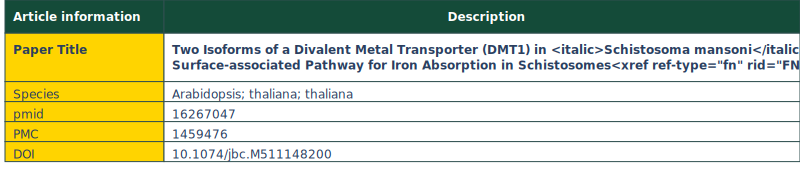

CPU times: user 3min 7s, sys: 2min 6s, total: 5min 14s
Wall time: 1min 2s


In [55]:
%%time
df_temp = read_pubmed('Example_data/PMC1459476.xml', 
                      sim_cutoff=0.90 ,Print=False, Method = "Offline")
G = Plot_data(df_temp)

<div class="alert alert-block alert-success">
    <h2><b>Example 2 (Good):</b> PMC1802096</h2>
    MOR1/GEM1 plays an essential role in the plant-specific cytokinetic phragmoplast. 
</div>

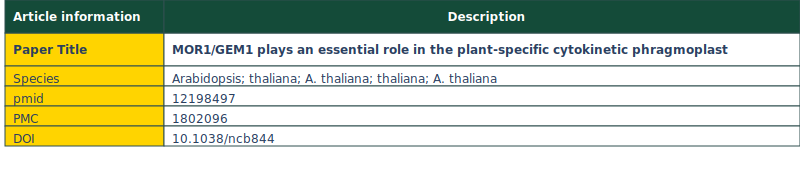

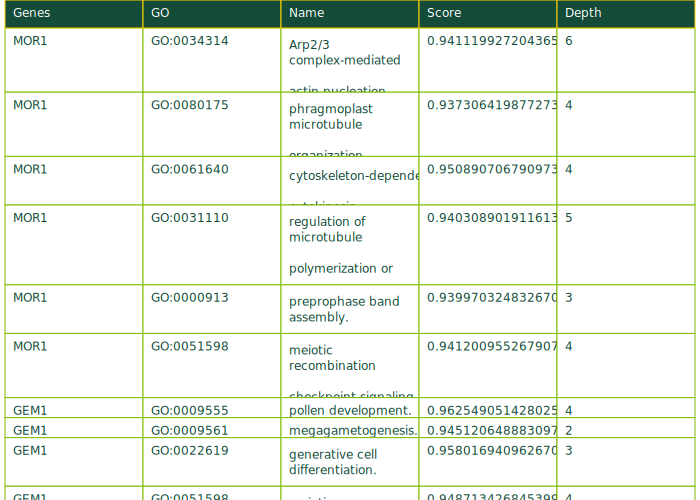

CPU times: user 1min 52s, sys: 1min 16s, total: 3min 8s
Wall time: 37.1 s


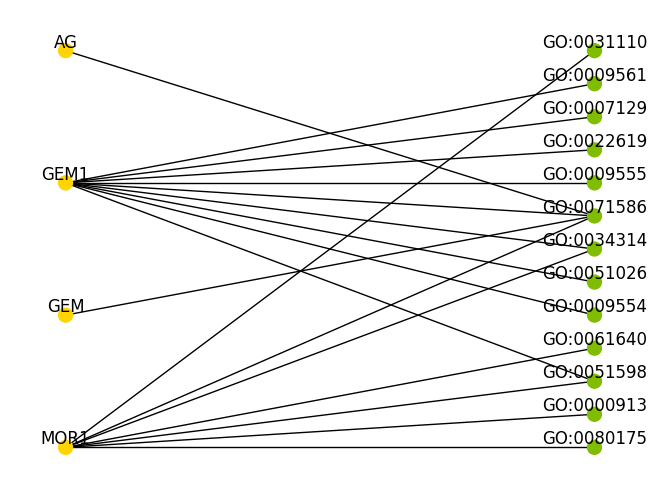

In [56]:
%%time
#####################################################
# Input method: Negative example
#####################################################
Out_def = read_pubmed('Example_data/PMC1802096.xml', 
                      Print=False, Method = "Offline", sim_cutoff=0.935)
Plot_data(Out_def)

In [57]:
session_info.show(html=False)

-----
bs4                 4.11.1
matplotlib          3.6.2
networkx            2.8.8
nltk                3.8
nlu                 4.0.0
numpy               1.23.5
pandas              1.5.2
plotly              5.3.1
requests            2.28.1
seaborn             0.12.2
session_info        1.0.0
sklearn             1.2.0
tqdm                4.49.0
-----
IPython             8.7.0
jupyter_client      7.4.8
jupyter_core        5.1.1
-----
Python 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:49:35) [GCC 10.4.0]
Linux-3.10.0-1160.24.1.el7.x86_64-x86_64-with-glibc2.10
-----
Session information updated at 2023-04-13 17:36
